# 1. 환경설정

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns



In [3]:
# 지수표현 없애기
pd.options.display.float_format = '{:.2f}'.format

# 2. 데이터 불러오기


In [4]:
device_path = 'dumps/hackle_csv/device_properties.csv'
events_path = 'dumps/hackle_csv/hackle_events.csv'
hackle_prop_path = 'dumps/hackle_csv/hackle_properties.csv'
user_path = 'dumps/hackle_csv/user_properties.csv'

In [5]:
raw_device = pd.read_csv(device_path)
raw_hackle_events = pd.read_csv(events_path)
raw_hackle_propeties = pd.read_csv(hackle_prop_path)
raw_user = pd.read_csv(user_path, dtype={0: str})

# 3. 데이터 확인

## 3-1. 기기 설정

In [6]:
raw_device.head()

,id,device_id,device_model,device_vendor
0,1,000007C9-E103-4EB5-9777-A9084D4952DF,"iPhone14,7",Apple
1,2,00002245-458F-4CDD-8533-B448CD43DBD2,"iPhone14,7",Apple
2,3,00012620-313A-4502-9F8D-8DAB7443215B,"iPhone14,5",Apple
3,4,000137bc-80de-4bb5-b61d-df7f217a4501,SM-F711N,samsung
4,5,000227D6-B782-4367-91C4-486B76DF9E37,"iPhone12,3",Apple


In [7]:
# 결측치 없음
raw_device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252380 entries, 0 to 252379
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             252380 non-null  int64 
 1   device_id      252380 non-null  object
 2   device_model   252380 non-null  object
 3   device_vendor  252380 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.7+ MB


In [8]:
# 전체중복값은 없음
raw_device.duplicated().sum()

np.int64(0)

In [9]:
# device_id 고유값이 다르다 = 중복값이 있다!
raw_device['device_id'].nunique()

251720

In [10]:
# device 중복행 660개
raw_device['device_id'].duplicated().sum()

np.int64(660)

In [11]:
# 기기가 바뀌었음. 모델은 상관 없으니까 keep=last로 남겨도 되나?
raw_device[raw_device['device_id'].duplicated(keep=False)].sort_values(by=['device_id', 'id']).head(10)

,id,device_id,device_model,device_vendor
16,17,0006bed8-512b-48f9-9b33-f79bb1e225a8,SM-A325N,samsung
17,18,0006bed8-512b-48f9-9b33-f79bb1e225a8,SM-S911N,samsung
704,705,00bf3a4e-4ef9-4a6a-8558-cc5f68d4041d,SM-A546S,samsung
705,706,00bf3a4e-4ef9-4a6a-8558-cc5f68d4041d,SM-A716S,samsung
1718,1719,01BBBADC-073C-4AEC-8C00-52F0A29577B4,"iPhone12,8",Apple
1719,1720,01BBBADC-073C-4AEC-8C00-52F0A29577B4,"iPhone14,4",Apple
1824,1825,01D2DB25-5EF6-447C-B3FA-63156C4DCBCF,"iPhone12,1",Apple
1825,1826,01D2DB25-5EF6-447C-B3FA-63156C4DCBCF,"iPhone14,5",Apple
2134,2135,021fd2a9-a0e5-42e8-b9d1-0c2244101869,SM-A315N,samsung
2135,2136,021fd2a9-a0e5-42e8-b9d1-0c2244101869,SM-S918N,samsung


In [12]:
raw_device['device_model'].nunique()

522

## 3-2. 해클 속성


In [68]:
raw_hackle_propeties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525350 entries, 0 to 525349
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           525350 non-null  int64 
 1   session_id   525350 non-null  object
 2   user_id      443095 non-null  object
 3   language     525350 non-null  object
 4   osname       525350 non-null  object
 5   osversion    525350 non-null  object
 6   versionname  525350 non-null  object
 7   device_id    525350 non-null  object
dtypes: int64(1), object(7)
memory usage: 32.1+ MB


In [69]:
raw_hackle_propeties.describe()

,id
count,525350.00
mean,262675.50
std,151655.63
min,1.00
25%,131338.25
50%,262675.50
75%,394012.75
max,525350.00


In [ ]:
# 전체 중복행 없음
raw_hackle_propeties.duplicated().sum()

np.int64(0)

In [ ]:
# 행은 50만개인데 session은 27만개
raw_hackle_propeties['session_id'].duplicated().sum()

np.int64(271734)

In [ ]:
# user_id에 결측치가 많네..?
# 이 데이터가 특정 기간의 log flow 기록이니까 비회원의 활동 내역일까?
raw_hackle_propeties.isna().sum()

id                 0
session_id         0
user_id        82255
language           0
osname             0
osversion          0
versionname        0
device_id          0
dtype: int64

In [ ]:
# 아이디가 없는 유저의 device_id 고유값
userid_isna = raw_hackle_propeties[raw_hackle_propeties['user_id'].isna()]
userid_isna['device_id'].nunique()

77445

In [ ]:
# 비회원의 device_id별 session 개수 평균
(userid_isna.groupby(by='device_id')['session_id'].count()).mean()

# 비회원과 회원의 device_id 비교 필요

np.float64(1.0621085931951708)

## 3-3. 해클 이벤트

In [13]:
raw_hackle_events.describe()

# 투표수 3천건 확인필요
# 하트 8억개? 확인필요

,friend_count,votes_count,heart_balance,question_id
count,10688763.00,10686765.00,10712676.00,449484.00
mean,54.34,257.27,16269.29,2766.39
std,33.51,218.07,3317340.09,1599.97
min,0.00,0.00,0.00,99.00
25%,32.00,97.00,434.00,1393.00
50%,49.00,210.00,1249.00,2569.00
75%,71.00,362.00,3188.00,4459.00
max,1365.00,3017.00,884999804.00,5133.00


In [14]:
raw_hackle_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   event_id        object 
 1   event_datetime  object 
 2   event_key       object 
 3   session_id      object 
 4   id              object 
 5   item_name       object 
 6   page_name       object 
 7   friend_count    float64
 8   votes_count     float64
 9   heart_balance   float64
 10  question_id     float64
dtypes: float64(4), object(7)
memory usage: 960.2+ MB


In [15]:
# events_key의 종류에 따라 나올 수 있는 결측치이기때문에 이벤트키 종류별로 확인해봐야할듯
raw_hackle_events.isna().sum()

event_id                 0
event_datetime           0
event_key                0
session_id               0
id                       0
item_name         11428280
page_name         10652540
friend_count        752556
votes_count         754554
heart_balance       728643
question_id       10991835
dtype: int64

In [28]:
raw_hackle_events.notna().sum()

event_id          11441319
event_datetime    11441319
event_key         11441319
session_id        11441319
id                11441319
item_name            13039
page_name           788779
friend_count      10688763
votes_count       10686765
heart_balance     10712676
question_id         449484
dtype: int64

In [16]:
print(f"{raw_hackle_events['item_name'].unique()}")
print(f"{raw_hackle_events['page_name'].unique()}")

[nan '777 하트' '무료충전소' '1000 하트' '200 하트' '4000 하트']
[nan 'notice' 'home' 'profile' '학교선택' '학년선택' '반선택' '번호인증' '성별선택' '아이디입력'
 '프사설정' 'invite' '이름입력']


In [ ]:
# # event_key에 특정된 컬럼의 결측치 여부
# # item_name
# item_eventkey = raw_hackle_events[raw_hackle_events['item_name'].notna()]['event_key']
# item_count = raw_hackle_events['item_name'].notna().sum()

# print(f"item_name 이벤트키 중 결측치: {'✅ 없음!' if item_eventkey.count() == item_count else '❌ 있음?'} \
#       \nevent_key = {item_eventkey.unique() if item_eventkey.nunique() <= 5 else item_eventkey.nunique()}")


In [ ]:
# event_key에 특정된 컬럼의 결측치 여부
target_columns = [
    'item_name', 'page_name', 'friend_count', 
    'votes_count', 'heart_balance', 'question_id'
]

for col in target_columns:

    non_null_data = raw_hackle_events[raw_hackle_events[col].notna()]
    event_keys = non_null_data['event_key']
    
    # 카운트 계산
    total_non_null = raw_hackle_events[col].notna().sum()
    current_count = event_keys.count()
    
    # 상태값 판단
    status = '✅ 없음!' if current_count == total_non_null else '❌ 있음?'
    
    # 출력할 정보 (5개 이하면 목록, 아니면 갯수)
    unique_keys = event_keys.unique()
    display_info = unique_keys if len(unique_keys) <= 5 else len(unique_keys)
    
    # 최종 출력
    print(f"{col} 이벤트키 중 결측치: {status}")
    print(f"event_key = {display_info}")
    print('-' * 10)

item_name 이벤트키 중 결측치: ✅ 없음!
event_key = ['click_purchase']
----------
page_name 이벤트키 중 결측치: ✅ 없음!
event_key = 9
----------
friend_count 이벤트키 중 결측치: ✅ 없음!
event_key = 42
----------
votes_count 이벤트키 중 결측치: ✅ 없음!
event_key = 41
----------
heart_balance 이벤트키 중 결측치: ✅ 없음!
event_key = 42
----------
question_id 이벤트키 중 결측치: ✅ 없음!
event_key = ['skip_question']
----------


In [ ]:
# hackle table merge
raw_hackle_merge = pd.merge(raw_hackle_propeties, raw_hackle_events, on='session_id')

In [50]:
# 하트가 가장 많은 유저
raw_hackle_events.loc[raw_hackle_events['heart_balance'].idxmax()]

event_id          01a583d7-b2b2-490b-96f6-1645b172ac0e
event_datetime                     2023-07-24 20:58:40
event_key                               $session_start
session_id                NnVWxmwjHcfnMENN9y4SrTPfcG82
id                01a583d7-b2b2-490b-96f6-1645b172ac0e
item_name                                          NaN
page_name                                          NaN
friend_count                                     65.00
votes_count                                      97.00
heart_balance                             884999804.00
question_id                                        NaN
Name: 73195, dtype: object

In [53]:
 # friend_count 가장 많은 유저 top10
friend_count_max = raw_hackle_merge.groupby('user_id').agg(max_friend=('friend_count', 'max')).sort_values(by='max_friend', ascending=False).reset_index(drop=False)
friend_count_max.head(10)

,user_id,max_friend
0,1353849,1365.00
1,1153340,1261.00
2,xrQ3bwiTWCQ5Da9d77f686NDs113,1261.00
3,877266,795.00
4,1zc5NMP9LPehQ7ARWfRfJOG1SjJ2,757.00
5,1496245,757.00
6,1395312,753.00
7,866386,694.00
8,957607,671.00
9,987572,619.00


In [60]:
# votes_count 가장 많은 유저 top10
votes_count_max = raw_hackle_merge.groupby('user_id').agg(max_votes=('votes_count', 'max')).sort_values(by='max_votes', ascending=False).reset_index(drop=False)
votes_count_max.head(10)

,user_id,max_votes
0,1375334,3017.00
1,1155373,2696.00
2,1125597,2548.00
3,1023199,2419.00
4,YYPgkedYLmhjaTy9XmD1LxiScR72,2419.00
5,1253878,2309.00
6,bL0TbwZAaxYmWLVpHzm0CxZzP772,2309.00
7,9LdChceXXHZd0PB0KGFKh6ZKzhr2,2210.00
8,1055839,2210.00
9,923457,2088.00


In [63]:
# heart_balance 하트가 많은 유저 top30
heart_balance_max = raw_hackle_merge.groupby('user_id').agg(max_heart=('heart_balance', 'max')).sort_values(by='max_heart', ascending=False).reset_index(drop=False)
heart_balance_max.head(20)

# 구매내역 확인해봐야할듯

,user_id,max_heart
0,833041,884999804.00
1,967442,703126260.00
2,849763,9991115.00
3,1437875,9991115.00
4,914589,263783.00
5,1563520,208894.00
6,1290502,151907.00
7,838541,100142.00
8,1577938,100142.00
9,1577930,100142.00


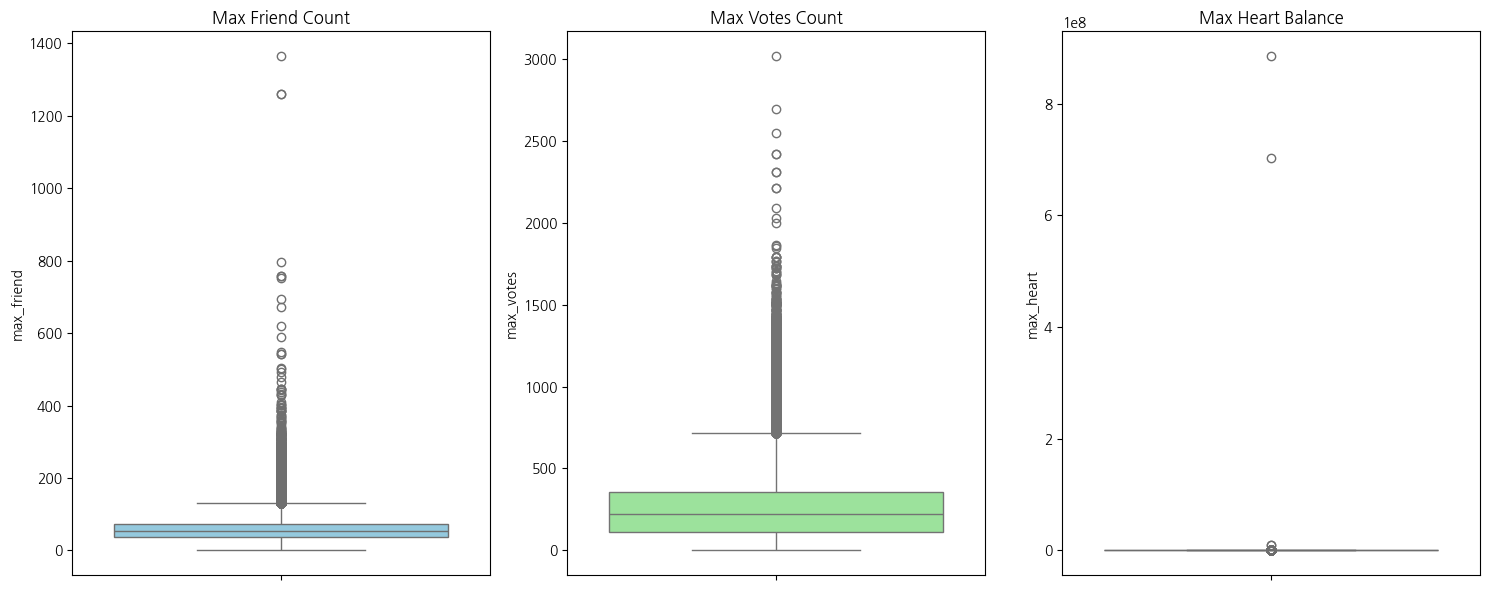

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(data=friend_count_max, y='max_friend', ax=axes[0], color='skyblue')
axes[0].set_title('Max Friend Count')

sns.boxplot(data=votes_count_max, y='max_votes', ax=axes[1], color='lightgreen')
axes[1].set_title('Max Votes Count')

sns.boxplot(data=heart_balance_max, y='max_heart', ax=axes[2], color='salmon')
axes[2].set_title('Max Heart Balance')

plt.tight_layout()
plt.show()